___
# <font color= #d4b1e6> **Laboratorio 2: Training Neural Networks** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez, Mónica Ibarra Herrera & Antonia Horburger` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Aprendizaje Máquina` </font>
___

### <font color= #d4b1e6> **Abstracto** </font>

### <font color= #d4b1e6> **Método** </font>

In [15]:
import os
import random
import math
import time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torchvision import transforms, datasets, models
from PIL import Image

from tqdm.auto import tqdm

### <font color= #d4b1e6> **Reproducibilidad** </font>

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


### <font color= #d4b1e6> **Configuración inicial** </font>

In [3]:
DATA_DIR = Path('./data')
RESULTS_DIR = Path('./results_autorun')
CHECKPOINTS_DIR = RESULTS_DIR/'checkpoints'
HISTORY_DIR = RESULTS_DIR/'history'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)
HISTORY_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
# Experiment hyperparams (reduce epochs for quick debugging)
N_EPOCHS = 30        # por defecto 60; puedes reducir para debug
BATCH_BASE = 128     # baseline
NUM_WORKERS = 4
N_SEEDS = 1          # =1 produce 45 modelos; set 3 to run 3 seeds per condition (much más caro)

# Set a default seed for deterministic config ordering
BASE_SEED = 42
set_seed(BASE_SEED)

### <font color= #d4b1e6> **Dataset & Dataloaders** </font>

In [19]:
IMG_SIZE = 224
NUM_CLASSES = 10

train_transform_baseline = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# We'll create a function to return loaders given batch_size and augmentation variant
def make_dataloaders(batch_size=BATCH_BASE, augmentation='baseline'):
    # download once
    train_full = datasets.CIFAR10(root=str(DATA_DIR), train=True, download=True,
                                  transform=(train_transform_baseline if augmentation=='baseline' else train_transform_baseline))
    test = datasets.CIFAR10(root=str(DATA_DIR), train=False, download=True, transform=val_transform)

    # 80/20 split of training into train/val as required
    n = len(train_full)
    n_train = int(0.8 * n)
    n_val = n - n_train
    train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(BASE_SEED))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader, test_loader

# quick check
_train, _val, _test = make_dataloaders(batch_size=64)
print("Sample counts -> train batches:", len(_train), "val batches:", len(_val), "test batches:", len(_test))

Sample counts -> train batches: 625 val batches: 157 test batches: 157


### <font color= #d4b1e6> **Mostrar imágenes** </font>

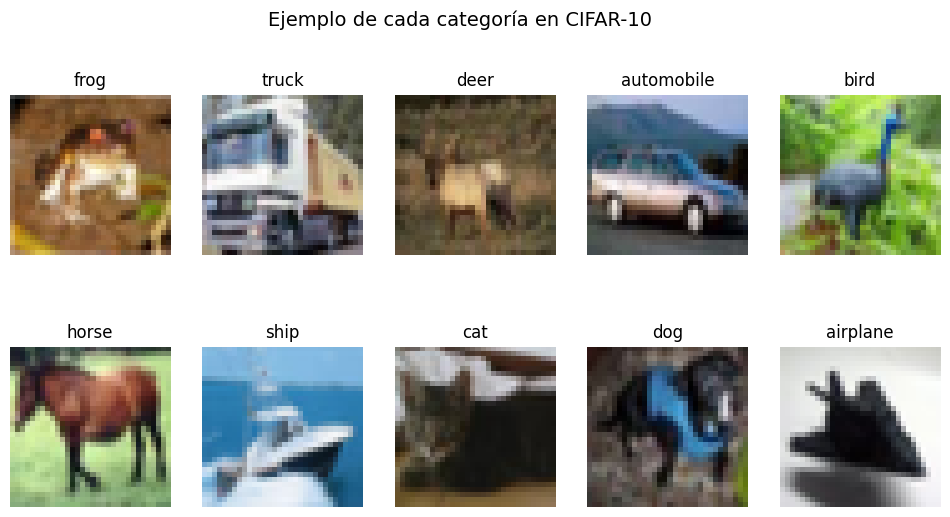

In [20]:
# --- 1️⃣ Transformación simple (sin normalizar para mostrar los colores reales)
show_transform = transforms.Compose([transforms.ToTensor()])

# --- 2️⃣ Cargar CIFAR-10
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=show_transform)

# --- 3️⃣ Obtener nombres de las clases
classes = dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# --- 4️⃣ Crear figura
plt.figure(figsize=(12, 6))
shown = set()

# --- 5️⃣ Recorremos el dataset hasta tener una muestra de cada clase
for img, label in dataset:
    label_name = classes[label]
    if label_name not in shown:
        plt.subplot(2, 5, len(shown) + 1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        plt.title(label_name)
        plt.axis("off")
        shown.add(label_name)
    if len(shown) == len(classes):
        break

plt.suptitle("Ejemplo de cada categoría en CIFAR-10", fontsize=14)
plt.show()


### <font color= #d4b1e6> **Definición de Modelos** </font>

In [21]:
def get_alexnet(num_classes=NUM_CLASSES, init_type='kaiming'):
    model = models.alexnet(weights=None)
    in_feat = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_feat, num_classes)
    apply_init(model, init_type)
    return model

def get_vgg11(num_classes=NUM_CLASSES, init_type='kaiming'):
    model = models.vgg11_bn(weights=None)
    in_feat = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_feat, num_classes)
    apply_init(model, init_type)
    return model

class CustomCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*4*4, 512), nn.ReLU(inplace=True),
            nn.Linear(512, 256), nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_custom(init_type='kaiming'):
    m = CustomCNN()
    apply_init(m, init_type)
    return m

# initialization helper
def apply_init(model, scheme='kaiming'):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            if scheme == 'kaiming':
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            elif scheme == 'xavier':
                nn.init.xavier_normal_(m.weight)
            elif scheme == 'orthogonal':
                nn.init.orthogonal_(m.weight)
            else:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if hasattr(m,'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            if hasattr(m,'weight') and m.weight is not None:
                nn.init.ones_(m.weight)
            if hasattr(m,'bias') and m.bias is not None:
                nn.init.zeros_(m.bias)

### <font color= #d4b1e6> **Entrenamiento y Validación** </font>

In [22]:
def accuracy_batch(output, target):
    with torch.no_grad():
        preds = torch.argmax(output, dim=1)
        return (preds==target).float().mean().item()

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    for imgs, labels in loader:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        bs = imgs.size(0)
        running_loss += loss.item()*bs
        running_acc += accuracy_batch(out, labels)*bs
        n += bs
    return running_loss/n, running_acc/n

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device); labels = labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            bs = imgs.size(0)
            running_loss += loss.item()*bs
            running_acc += accuracy_batch(out, labels)*bs
            n += bs
    return running_loss/n, running_acc/n

### <font color= #d4b1e6> **Learning Rate Scheduling** </font>

In [23]:
def make_scheduler(optimizer, schedule_name, epochs, warmup_epochs=5, base_lr=0.1, steps_per_epoch=None):
    if schedule_name == 'onecycle':
        if steps_per_epoch is None:
            raise ValueError("steps_per_epoch required for OneCycle")
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=base_lr, total_steps=epochs*steps_per_epoch)
        return scheduler
    elif schedule_name == 'cosine':
        # we'll use LambdaLR with warmup
        def lr_lambda(ep):
            if ep < warmup_epochs:
                return float(ep+1)/float(warmup_epochs)
            # cosine annealing after warmup
            t = (ep-warmup_epochs)/(epochs-warmup_epochs)
            return 0.5*(1+np.cos(np.pi*t))
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    elif schedule_name == 'step':
        # step at 30 & 50 (if epochs > those)
        def lr_lambda(ep):
            if ep < warmup_epochs:
                return float(ep+1)/float(warmup_epochs)
            e = ep - warmup_epochs
            if e < 25: return 1.0
            elif e < 45: return 0.1
            else: return 0.01
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    else:
        # constant with warmup
        def lr_lambda(ep):
            return float(ep+1)/float(warmup_epochs) if ep < warmup_epochs else 1.0
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### <font color= #d4b1e6> **Ejemplo de uso prueba** </font>

In [24]:
def lr_range_test(build_model_fn, train_loader, optimizer_cls, start_lr=1e-6, end_lr=1.0, iters=100):
    model = build_model_fn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_cls(model.parameters(), lr=start_lr)
    lrs = []
    losses = []
    itr = 0
    for imgs, labels in train_loader:
        imgs = imgs.to(device); labels = labels.to(device)
        lr = start_lr * (end_lr/start_lr)**(itr/iters)
        for g in optimizer.param_groups:
            g['lr'] = lr
        out = model(imgs)
        loss = criterion(out, labels)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        lrs.append(lr); losses.append(loss.item())
        itr += 1
        if itr >= iters:
            break
    return lrs, losses


### <font color= #d4b1e6> **Configuración de Experimentos** </font>

In [12]:
MODELS = ['alexnet','vgg','custom']
AXIS = {}

# Axis A: Optimizers (3 variants)
AXIS['A'] = [
    {'tag':'sgd',   'opt': {'name':'sgd',   'lr':0.1,  'weight_decay':5e-4, 'nesterov':False}},
    {'tag':'sgd_n', 'opt': {'name':'sgd',   'lr':0.1,  'weight_decay':5e-4, 'nesterov':True}},
    {'tag':'adamw', 'opt': {'name':'adamw', 'lr':1e-3, 'weight_decay':1e-2}}
]

# Axis B: Regularization (3 variants)
AXIS['B'] = [
    {'tag':'wd_1e-4',  'reg': {'weight_decay':1e-4, 'dropout':0.0, 'label_smoothing':0.0, 'mixup':False}},
    {'tag':'dropout_0.2','reg': {'weight_decay':5e-4, 'dropout':0.2, 'label_smoothing':0.0, 'mixup':False}},
    {'tag':'mixup_ls', 'reg': {'weight_decay':5e-4, 'dropout':0.0, 'label_smoothing':0.1, 'mixup':True, 'mixup_alpha':0.2}}
]

# Axis C: Batch sizes (3 variants)
AXIS['C'] = [
    {'tag':'bs32',  'batch_size':32},
    {'tag':'bs128', 'batch_size':128},
    {'tag':'bs512', 'batch_size':512}
]

# Axis D: LR schedules (3 variants)
AXIS['D'] = [
    {'tag':'const',  'schedule':{'name':'constant'}},
    {'tag':'step',   'schedule':{'name':'step'}},
    {'tag':'cosine', 'schedule':{'name':'cosine'}}
]

# Axis E: Initializations (3 variants)
AXIS['E'] = [
    {'tag':'kaiming', 'init':'kaiming'},
    {'tag':'xavier',  'init':'xavier'},
    {'tag':'orth',    'init':'orthogonal'}
]

# baseline config
BASE = {
    'init': 'kaiming',
    'optimizer': {'name':'sgd','lr':0.1,'weight_decay':5e-4,'nesterov':False},
    'schedule': {'name':'cosine'},
    'batch_size': BATCH_BASE,
    'reg': {'weight_decay':5e-4, 'dropout':0.0, 'label_smoothing':0.0, 'mixup':False},
    'epochs': N_EPOCHS,
    'warmup':5,
}

### <font color= #d4b1e6> **Runner that executes one configuration (model+config) and saves history & checkpoint** </font>

In [25]:
def build_model_by_name(name, init_type='kaiming'):
    if name == 'alexnet':
        return get_alexnet(init_type=init_type)
    elif name == 'vgg':
        return get_vgg11(init_type=init_type)
    elif name == 'custom':
        return get_custom(init_type=init_type)
    else:
        raise ValueError(name)

def run_single(model_name, cfg, seed, out_prefix):
    # set seed
    set_seed(seed)

    # dataloaders based on batch_size and augmentation (augmentation toggle in cfg['reg'] if needed)
    bs = cfg.get('batch_size', BASE['batch_size'])
    train_loader, val_loader, test_loader = make_dataloaders(batch_size=bs)

    # build model
    init_type = cfg.get('init', BASE['init'])
    if model_name == 'alexnet':
        model = get_alexnet(num_classes=NUM_CLASSES, init_type=init_type)
    elif model_name == 'vgg':
        model = get_vgg11(num_classes=NUM_CLASSES, init_type=init_type)
    else:
        model = get_custom(init_type=init_type)
    model = model.to(device)

    # maybe apply dropout changes (for custom model we can change classifier dropout if needed — here we skip structural edits for simplicity)
    # criterion (support label smoothing manually if >0)
    label_smoothing = cfg.get('reg', {}).get('label_smoothing', 0.0)
    if label_smoothing > 0:
        # we'll use a custom loss wrapper
        criterion = nn.CrossEntropyLoss()  # used in helper below when not smoothing; we'll implement smoothing in loop
    else:
        criterion = nn.CrossEntropyLoss()

    # optimizer
    opt_cfg = cfg.get('optimizer', BASE['optimizer'])
    if opt_cfg['name'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=opt_cfg['lr'], momentum=0.9, weight_decay=opt_cfg.get('weight_decay',0.0), nesterov=opt_cfg.get('nesterov',False))
    elif opt_cfg['name'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay',0.0))
    elif opt_cfg['name'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=opt_cfg['lr'], weight_decay=opt_cfg.get('weight_decay',0.0))
    else:
        raise ValueError(opt_cfg['name'])

    # scheduler
    sched_cfg = cfg.get('schedule', BASE['schedule'])
    scheduler = make_scheduler(optimizer, sched_cfg['name'], epochs=cfg['epochs'], warmup_epochs=cfg.get('warmup',5), base_lr=opt_cfg.get('lr',0.1), steps_per_epoch=len(train_loader))

    # mixup
    do_mixup = cfg.get('reg',{}).get('mixup', False)
    mixup_alpha = cfg.get('reg',{}).get('mixup_alpha', 0.2)

    # training loop
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'lr':[]}
    best_val = -1
    best_epoch = -1

    for epoch in range(cfg['epochs']):
        model.train()
        train_loss = 0.0; train_acc = 0.0; n_train = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            optimizer.zero_grad()
            if do_mixup:
                # simple mixup
                lam = np.random.beta(mixup_alpha, mixup_alpha)
                idx = torch.randperm(imgs.size(0)).to(imgs.device)
                imgs_mix = lam*imgs + (1-lam)*imgs[idx]
                out = model(imgs_mix)
                loss = lam*F.cross_entropy(out, labels) + (1-lam)*F.cross_entropy(out, labels[idx])
            else:
                out = model(imgs)
                if label_smoothing > 0:
                    # label smoothing: compute smoothed loss
                    num_classes = out.size(1)
                    log_probs = F.log_softmax(out, dim=1)
                    with torch.no_grad():
                        true_dist = torch.zeros_like(out)
                        true_dist.fill_(label_smoothing/(num_classes-1))
                        true_dist.scatter_(1, labels.data.unsqueeze(1), 1.0-label_smoothing)
                    loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))
                else:
                    loss = F.cross_entropy(out, labels)
            loss.backward()
            optimizer.step()

            bs_curr = imgs.size(0)
            train_loss += loss.item()*bs_curr
            train_acc += (out.argmax(dim=1)==labels).float().sum().item()
            n_train += bs_curr

            # onecycle step per batch if used
            if isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
                scheduler.step()

        train_loss /= n_train
        train_acc /= n_train

        # validation
        val_loss, val_acc = validate(model, val_loader, F.cross_entropy if label_smoothing==0 else criterion, device)

        # scheduler step (if not OneCycle)
        if not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()

        lr_now = optimizer.param_groups[0]['lr']
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(lr_now)

        # save best
        if val_acc > best_val:
            best_val = val_acc
            best_epoch = epoch
            ckpt = {
                'model_name': model_name,
                'cfg': cfg,
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_val': best_val
            }
            ckpt_path = CHECKPOINTS_DIR/f"{out_prefix}_best.pth"
            torch.save(ckpt, ckpt_path)

        print(f"[{out_prefix}] Ep {epoch+1}/{cfg['epochs']}  tr_acc={train_acc:.4f} val_acc={val_acc:.4f} lr={lr_now:.6f}")

    # final save history
    hist_path = HISTORY_DIR/f"{out_prefix}_history.pkl"
    with open(hist_path, 'wb') as f:
        pickle.dump(history, f)

    return {'best_val': best_val, 'best_epoch': best_epoch, 'history_path': str(hist_path)}

### <font color= #d4b1e6> **Orchestrator: build all configs and run them** </font>

In [26]:
summary_rows = []

# helper to merge base + axis variant config
def merge_cfg(base, override):
    cfg = dict(base)  # shallow copy
    # deep-merge some fields
    cfg.update({k:v for k,v in override.items() if k not in ['opt','reg','schedule','batch_size','init']})
    if 'opt' in override:
        cfg['optimizer'] = override['opt']
    if 'reg' in override:
        cfg['reg'] = override['reg']
    if 'schedule' in override:
        cfg['schedule'] = override['schedule']
    if 'batch_size' in override:
        cfg['batch_size'] = override['batch_size']
    if 'init' in override:
        cfg['init'] = override['init']
    return cfg

# Loop axes A..E
axes_order = ['A','B','C','D','E']
total_runs = 0
for axis in axes_order:
    variants = AXIS[axis]
    for var in variants:
        var_tag = var['tag']
        # build cfg for this axis variant
        cfg = dict(BASE)  # start from base
        # overlay depending on axis
        if axis == 'A':
            cfg['optimizer'] = var['opt']
        elif axis == 'B':
            cfg['reg'] = var['reg']
        elif axis == 'C':
            cfg['batch_size'] = var['batch_size']
        elif axis == 'D':
            cfg['schedule'] = var['schedule']
        elif axis == 'E':
            cfg['init'] = var['init']
        # run for each model
        for model_name in MODELS:
            for seed_idx in range(N_SEEDS):
                seed = BASE_SEED + seed_idx + total_runs  # make deterministic varied seeds
                run_tag = f"{axis}_{var_tag}_{model_name}_s{seed_idx}"
                print("\n===== RUN:", run_tag, "seed", seed, "=====")
                out = run_single(model_name, cfg, seed, out_prefix=run_tag)
                summary_rows.append({
                    'axis': axis,
                    'variant': var_tag,
                    'model': model_name,
                    'seed_index': seed_idx,
                    'seed': seed,
                    'best_val': out['best_val'],
                    'best_epoch': out['best_epoch'],
                    'history_path': out['history_path']
                })
                total_runs += 1

# save summary CSV
df_summary = pd.DataFrame(summary_rows)
df_summary.to_csv(RESULTS_DIR/'summary_runs.csv', index=False)
print("All runs finished. Summary saved to", RESULTS_DIR/'summary_runs.csv')
print("Total runs:", total_runs)



===== RUN: A_sgd_alexnet_s0 seed 42 =====


c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 

### <font color= #d4b1e6> **Graficar resultados** </font>

In [ ]:
df = pd.read_csv(RESULTS_DIR/'summary_runs.csv')
agg = df.groupby(['axis','variant','model']).agg(mean_val=('best_val','mean'), std_val=('best_val','std'), n=('best_val','count')).reset_index()
display(agg)
agg.to_csv(RESULTS_DIR/'summary_agg.csv', index=False)

# Example plot: best_val per model for a chosen axis
import seaborn as sns
sns.set(style="whitegrid")
for axis in axes_order:
    sub = agg[agg['axis']==axis]
    plt.figure(figsize=(8,4))
    sns.barplot(data=sub, x='variant', y='mean_val', hue='model')
    plt.title(f'Axis {axis} — mean validation acc (best epoch)')
    plt.ylim(0,1.0)
    plt.show()

### <font color= #d4b1e6> **Resultados** </font>

### <font color= #d4b1e6> **Análisis** </font>

### <font color= #d4b1e6> **Limitaciones** </font>

### <font color= #d4b1e6> **Referencias** </font>